<a href="https://colab.research.google.com/github/calamistratus/Titanic_project/blob/main/Titanic_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
 #  Fixes NaNs based on parametres provided.
 #  With no 'by' and 'gentle=False' fills NaNs with 0 or 'no'.
 #  With no 'by' and 'gentle=True' fills NaNs with either most popular object or mean of the dataframe.
 #  With array of 'by' columns makes a groupby and fills NaNs based on their parameters.
 #  With non-False 'by', scaler, model, and a goal(A target variable column name) fills NaNs based on a predictions of a given model based on other parameters.

def fix_na(series, gentle=False, by=[], dataframe=None, model=None, scaler=None, goal=''):
    if type(series) == str:
        series = dataframe[series]
    if by:
        if gentle:
            dataframe = dataframe.drop(goal, axis=1)
            for i in check_na(dataframe).keys().drop(series.name):
               fix_na_set(dataframe, i, True)

            train = pd.get_dummies(dataframe.drop(series.name, axis=1), drop_first=True)
            y = dataframe[series.name][~dataframe[series.name].isnull()]
            X = train[~dataframe[series.name].isnull()]
            X = scaler.fit_transform(X)

            model.fit(X, y)

            return series.fillna(pd.Series(model.predict(scaler.fit_transform(train))))

        else:
            #if by is str:
                #by = [by]
            match series.dtype:
                case 'float64':
                    groupby = dataframe.groupby(by)[series.name].mean()
                    key = series.mean()

                    def pick_pop(by_data):
                        if [1 for i in by_data if i is np.nan]:
                            return groupby.iloc[0]
                        else:
                            try:
                                return groupby[by_data]
                            except:
                                return key

                    return series.fillna(pd.Series(np.vectorize(pick_pop)(*[df[i] for i in by])))

                case 'object':
                    groupby = dataframe.groupby(by)[series.name].value_counts()
                    key = series.value_counts().keys()[0]

                    def pick_pop(*by_data):
                        if [1 for i in [by_data] if i is np.nan]:
                            x = eval('groupby.keys()[1]' + '[1]' * len([by_data]))
                            return x
                        else:
                            try:
                                return groupby[by_data].keys()[0]
                            except:
                                return key

                    return series.fillna(pd.Series(np.vectorize(pick_pop)(*[df[i] for i in by])))

    else:
        if gentle:
            match series.dtype:
                case 'float64':
                    return series.fillna(series.mean())
                case 'object':
                    return series.fillna(list(series.value_counts().keys())[0])

        else:
            match series.dtype:
                case 'float64':
                    return series.fillna(0)
                case 'object':
                    return series.fillna('no')


def fix_na_set(dataframe, column, gentle = False, by='', model=None, scaler=None, goal=''): #  Automatically sets the fixed column into a dataframe.
    dataframe[column] = fix_na(series = dataframe[column], gentle = gentle, by = by, dataframe = dataframe, model=model, scaler=scaler, goal=goal)



def check_na(dataframe, column = ''): #   Checks for NaNs in dataframe, if the column is provided, gives a more detailed summary
    if column:
        print('\n', dataframe[column].value_counts().head(10), '\n\n', 'Number of na:', dataframe[column].isnull().sum(), '\n')
        return pd.concat([dataframe[dataframe[column].isnull() > 0].head(),
                          dataframe.head(1) == np.nan,
                          dataframe.sample(len(dataframe[dataframe[column].isnull() > 0].head()))], axis=0)
    else:
        return dataframe.isnull().sum()[dataframe.isnull().sum() > 0]

In [114]:
#  Functions for 'Ticket' and 'Cabin' cleanup
'''
def select(my_str):
    my_str = my_str.split()
    for i in my_str:
        if not i.isdigit():
            return i
            break
    else:
        return 'no'

def only_important(my_str, num=9):
    try:
        if counts.loc[my_str] < num:
            return 'no'
        else:
            return my_str
    except KeyError:
        return 'no'
''';

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

df = pd.concat([train, test], axis=0, ignore_index=True)

In [ ]:
df['Pclass'] = df['Pclass'].apply(str)
df = df.drop(['Name', 'Cabin', 'Ticket'], axis=1)
df = df.set_index('PassengerId')

In [115]:
#  Cleaning for 'Ticket' parameter. Too many ubscure parameters for it to be actually effective
'''
df['Ticket'] = df['Ticket'].apply(select)
counts = df['Ticket'].value_counts()
df['Ticket'] = df['Ticket'].apply(only_important)
''';

In [ ]:
check_na(df)

,0
Survived,418
Age,263
Fare,1
Embarked,2


In [ ]:
check_na(df, 'Fare')


 Fare
8.0500     60
13.0000    59
7.7500     55
26.0000    50
7.8958     49
10.5000    35
7.7750     26
7.2292     24
7.9250     23
26.5500    22
Name: count, dtype: int64 

 Number of na: 1 



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
1044,NaN,3,male,60.5,0,0,NaN,S
1,0.0,False,False,0.0,0,0,False,False
1079,NaN,3,male,17.0,2,0,8.05,S


In [ ]:
fix_na_set(df, 'Fare', False, ['Pclass']) #  Filling missing 'Fare' values by grouping dataframe by 'Pclass' column.

In [ ]:
check_na(df)

,0
Survived,418
Age,263
Embarked,2


In [116]:
#  Section for 'Cabin' parameter, cleansing it, fixing via simple moder predictons, and categorizing has led to no avail, mostly because its 92% NaN.

'''
c = df['Cabin'].apply(lambda x: [i for i in str(x) if i.isalpha() and not x is np.nan])
c = c.apply(lambda x: x[0] if len(x) == 1 else 'no')
counts = c.value_counts()
c = c.apply(only_important)

df['Cabin_letter'] = c
df = df.drop('Cabin', axis=1).sort_index()
''';

In [ ]:
check_na(df, 'Embarked')


 Embarked
S    914
C    270
Q    123
Name: count, dtype: int64 

 Number of na: 2 



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
62,1.0,1,female,38.0,0,0,80.0,NaN
830,1.0,1,female,62.0,0,0,80.0,NaN
1,0.0,False,False,0.0,0,0,0.0,False
761,0.0,3,male,NaN,0,0,14.5,S
222,0.0,2,male,27.0,0,0,13.0,S


In [ ]:
fix_na_set(df, 'Embarked', True) #  Filling missing embarked with the most popular value, only two NaN's so it shouldn't be that big if an issue

In [ ]:
check_na(df, 'Age')


 Age
24.0    47
22.0    43
21.0    41
30.0    40
18.0    39
25.0    34
28.0    32
36.0    31
27.0    30
26.0    30
Name: count, dtype: int64 

 Number of na: 263 



,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,
6,0.0,3,male,NaN,0,0,8.4583,Q
18,1.0,2,male,NaN,0,0,13.0000,S
20,1.0,3,female,NaN,0,0,7.2250,C
27,0.0,3,male,NaN,0,0,7.2250,C
29,1.0,3,female,NaN,0,0,7.8792,Q
1,0.0,False,False,False,0,0,0.0000,False
897,NaN,3,male,14.0,0,0,9.2250,S
319,1.0,1,female,31.0,0,2,164.8667,S
497,1.0,1,female,54.0,1,0,78.2667,C


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

fix_na_set(df, 'Age', True, True, GradientBoostingRegressor(), StandardScaler(), 'Survived') #  Filling missing 'Age' values via GradientBoostingRegressor, judging on data from other columns.
fix_na_set(df, 'Age', True) #  Cleanup

In [ ]:
groupby = df.groupby('Pclass')['Fare'].value_counts()

df['Fare_class_dif'] = df['Fare'] - df['Pclass'].apply(lambda x: groupby[x].keys()[0])
df['Fare_dif'] = df['Fare'] - df['Fare'].mean()
df['Age_dif'] = df['Age'] - df['Age'].mean() #  Some data engineering atop, difference from mean Age and Fare values, with extra difference of "Fare" with mean per 'Pclass'.

In [ ]:
check_na(df) #  NaNs cleansed.

,0
Survived,418


In [ ]:
df_dum_stat = pd.get_dummies(df) #  Purely for statistics.
df_dum = pd.get_dummies(df, drop_first=True)

corr = df_dum_stat.corr()

<ipython-input-117-5a567f5fc411>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(corr['Survived'].sort_values().drop('Survived'), orient='h', palette='viridis')


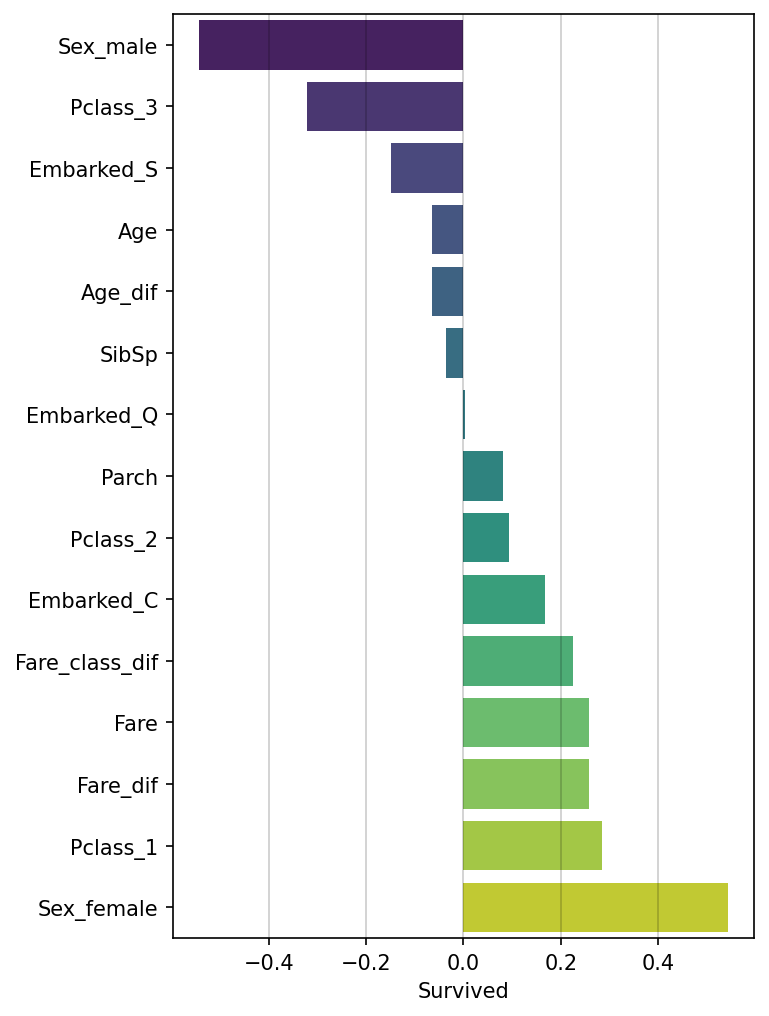

In [117]:
plt.figure(dpi=150, figsize=(5,8))
sns.barplot(corr['Survived'].sort_values().drop('Survived'), orient='h', palette='viridis')
plt.grid(True, alpha=.2, color='black', axis='x')
plt.show()

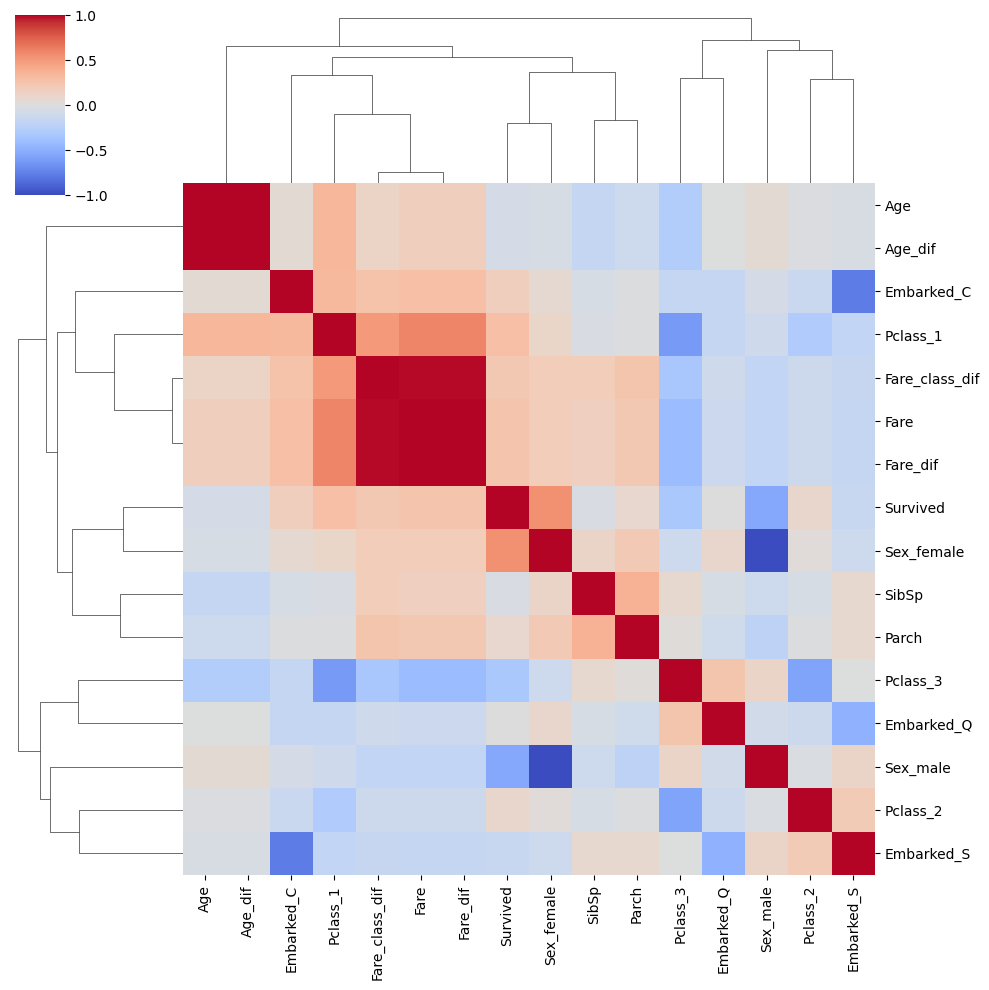

In [102]:
sns.clustermap(corr, cmap='coolwarm')
plt.show()

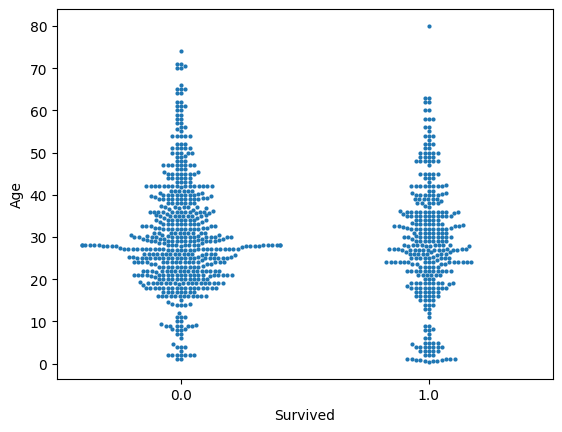

In [103]:
sns.swarmplot(data=df, y='Age', x='Survived', s=3)
plt.show()

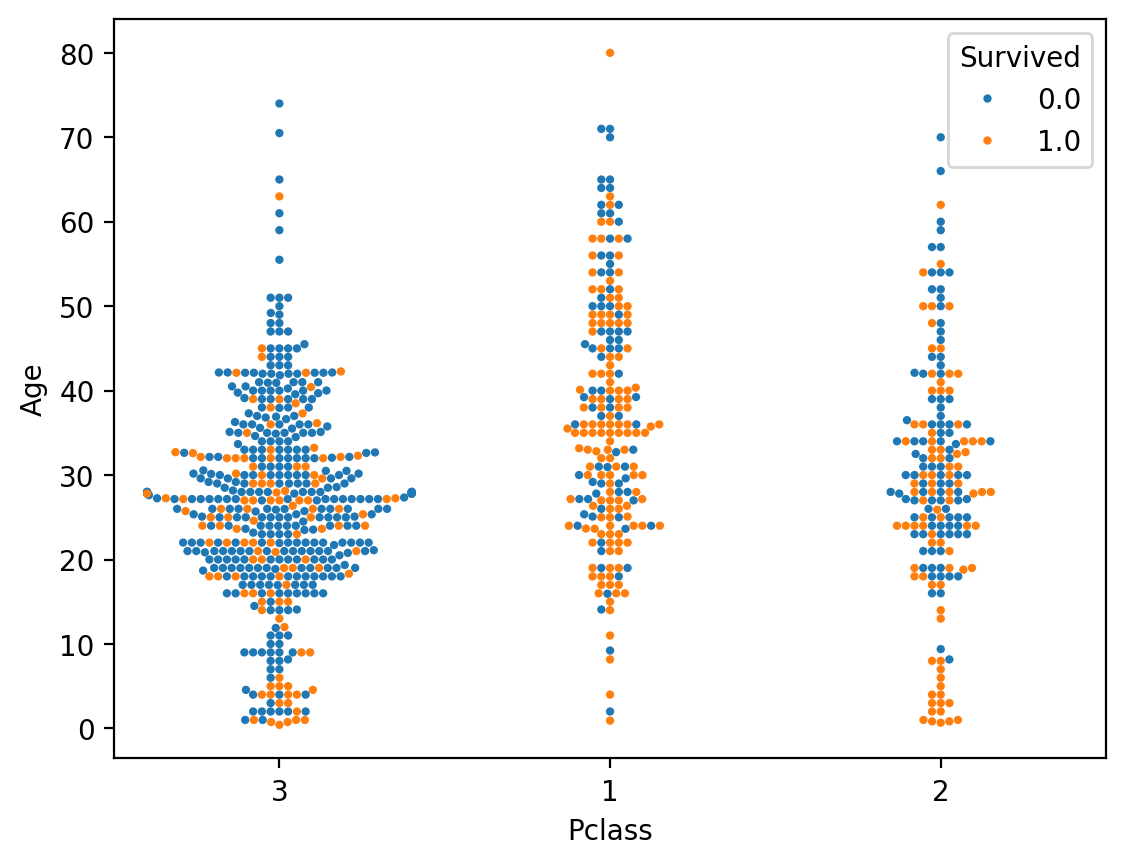

In [104]:
plt.figure(dpi=200)
sns.swarmplot(data=df, x='Pclass', y='Age', s=3, hue='Survived')
plt.show()

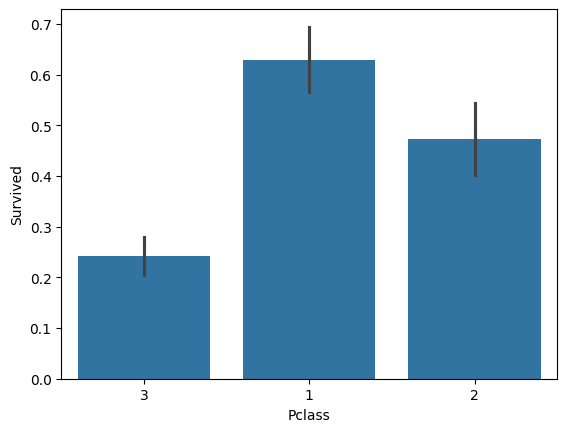

In [105]:
sns.barplot(data=df, x='Pclass', y='Survived')
plt.show()

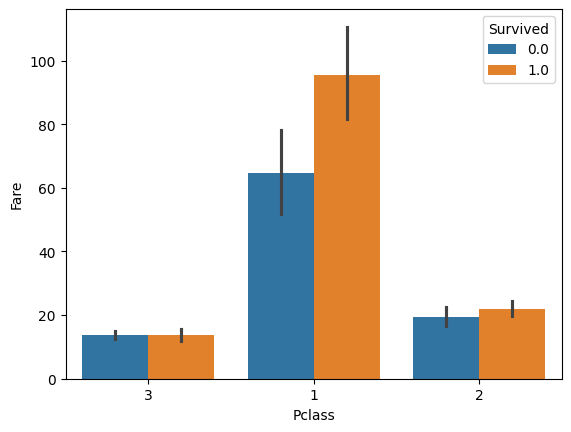

In [106]:
sns.barplot(data=df, hue='Survived', y='Fare', x='Pclass')
plt.show()

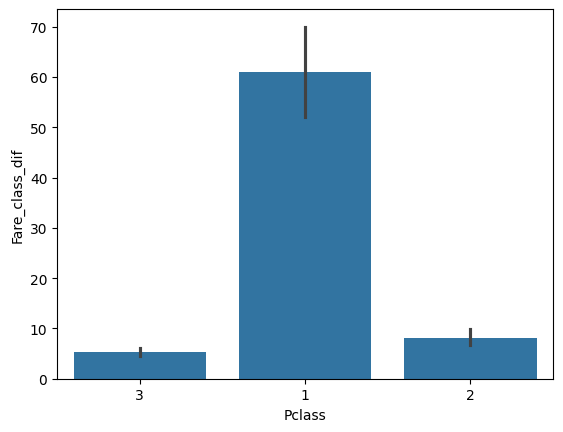

In [107]:
sns.barplot(data=df, y='Fare_class_dif', x='Pclass')
plt.show()

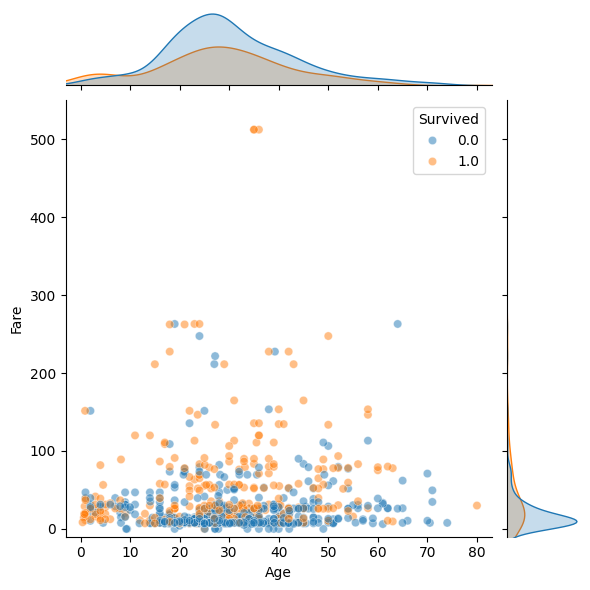

In [108]:
sns.jointplot(data=df, x='Age', y='Fare', hue='Survived', alpha=.5, xlim=(-3, 83), ylim=(-10, 550))
plt.show()

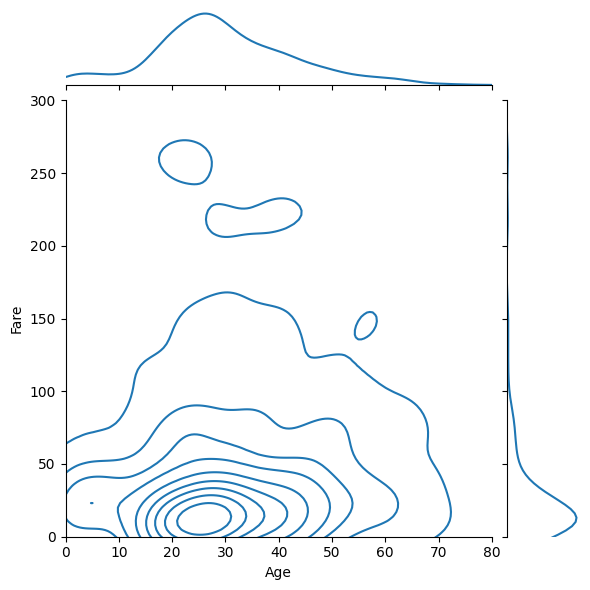

In [109]:
sns.jointplot(data=df, x='Age', y='Fare', kind='kde', xlim=(0, 80), ylim=(0, 300))
plt.show()

In [ ]:
train_dum = df_dum[~df_dum['Survived'].isnull()]
test_dum = df_dum[df_dum['Survived'].isnull()].drop('Survived', axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures #  Polynomial features were proven to be ineffective with this data
from sklearn.model_selection import train_test_split

X = train_dum.drop('Survived', axis=1)
y = train_dum['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

scaler = StandardScaler().fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)
scaled_X = scaler.fit_transform(X)

#poly = PolynomialFeatures().fit(X_train)

#poly_X_train = poly.transform(X_train)
#poly_X_test = poly.transform(X_test)
#poly_X = poly.fit_transform(X)

#poly_scaler = StandardScaler().fit(poly_X_train)

#oly_X_train = poly_scaler.transform(poly_X_train)
#poly_X_test = poly_scaler.transform(poly_X_test)
#poly_X = poly_scaler.fit_transform(poly_X)

scaled_test = scaler.transform(test_dum)
#poly_test = poly_scaler.transform(poly.transform(test_dum))

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.model_selection import GridSearchCV

#Functions for simple model testing

def test_model(model, sample=None, random_state=42):

  if sample:
    sub_df = pd.DataFrame(scaled_X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=42)

    model.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    model.fit(scaled_X_train, y_train)

  preds = model.predict(scaled_X_test)

  ConfusionMatrixDisplay.from_predictions(y_test, preds)
  RocCurveDisplay.from_predictions(y_test, preds)
  #print(classification_report(y_test, preds))
  return model

def test_grid(model, param_grid, sample=None, random_state=42, verbose=2, cv=3):
  grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=cv, verbose=verbose)

  if sample:
    sub_df = pd.DataFrame(scaled_X_train)
    sub_df['goal'] = np.array(y_train)
    sub_df = sub_df.sample(frac=sample, random_state=random_state)

    grid.fit(sub_df.drop('goal', axis=1), sub_df['goal'])
  else:
    grid.fit(scaled_X_train, y_train)
  preds = grid.predict(scaled_X_test)

  ConfusionMatrixDisplay.from_predictions(y_test, preds)
  RocCurveDisplay.from_predictions(y_test, preds)
  #print(classification_report(y_test, preds))
  print(grid.best_params_)
  return grid

[Text(0.5, 0.875, 'Sex_male <= -0.324\ngini = 0.472\nsamples = 801\nvalue = [495.0, 306.0]'),
 Text(0.25, 0.625, 'Pclass_3 <= -0.109\ngini = 0.385\nsamples = 277\nvalue = [72, 205]'),
 Text(0.375, 0.75, 'True  '),
 Text(0.125, 0.375, 'Age_dif <= -2.005\ngini = 0.078\nsamples = 148\nvalue = [6, 142]'),
 Text(0.0625, 0.125, 'gini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.1875, 0.125, 'gini = 0.066\nsamples = 146\nvalue = [5, 141]'),
 Text(0.375, 0.375, 'Fare_dif <= -0.175\ngini = 0.5\nsamples = 129\nvalue = [66, 63]'),
 Text(0.3125, 0.125, 'gini = 0.486\nsamples = 103\nvalue = [43.0, 60.0]'),
 Text(0.4375, 0.125, 'gini = 0.204\nsamples = 26\nvalue = [23, 3]'),
 Text(0.75, 0.625, 'Age <= -1.709\ngini = 0.311\nsamples = 524\nvalue = [423, 101]'),
 Text(0.625, 0.75, '  False'),
 Text(0.625, 0.375, 'SibSp <= 1.743\ngini = 0.435\nsamples = 25\nvalue = [8, 17]'),
 Text(0.5625, 0.125, 'gini = 0.111\nsamples = 17\nvalue = [1, 16]'),
 Text(0.6875, 0.125, 'gini = 0.219\nsamples = 8\nvalue = [7

<Figure size 1920x1440 with 0 Axes>

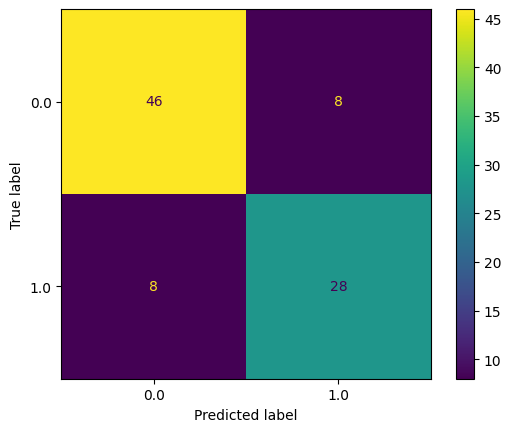

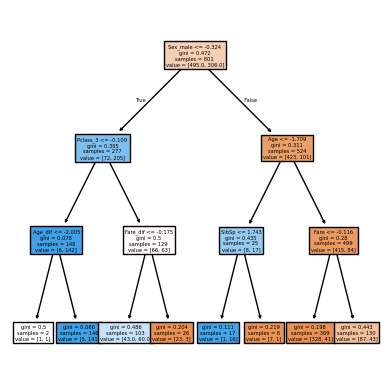

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

plt.figure(dpi=300)
plot_tree(test_model(DecisionTreeClassifier(max_depth=3)), feature_names=train_dum.drop('Survived', axis=1).columns, filled=True)
#  Simple and effective

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))

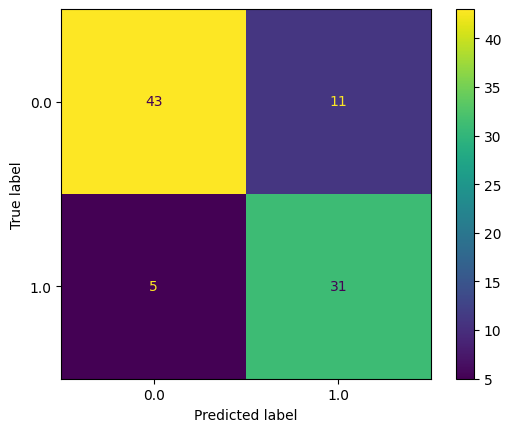

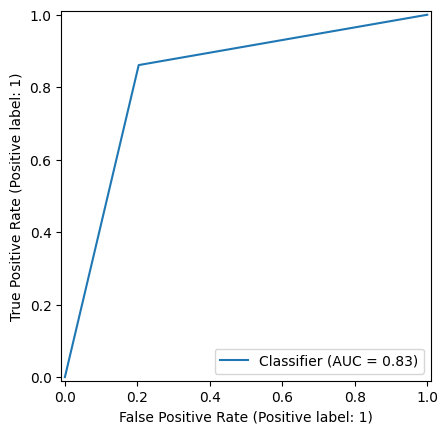

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=3))

test_model(ada)
#  Best by far

GradientBoostingClassifier()

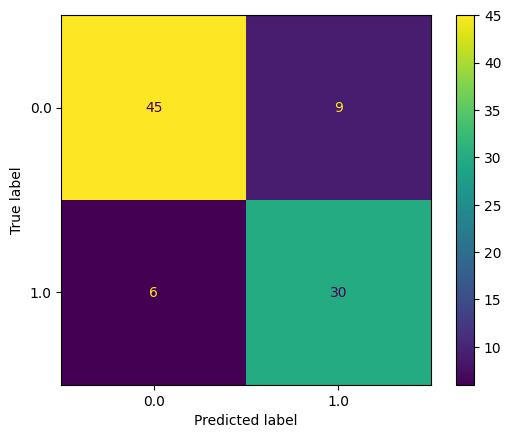

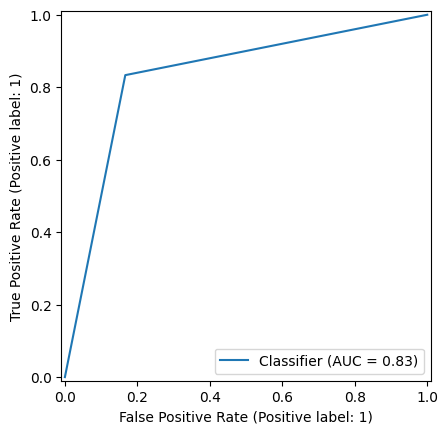

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

test_model(GradientBoostingClassifier())
#  High varience, decent candidate though

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

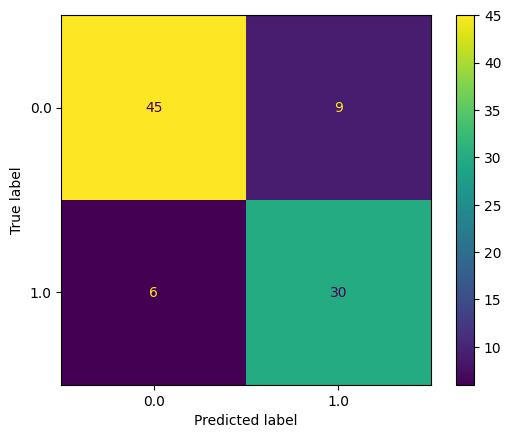

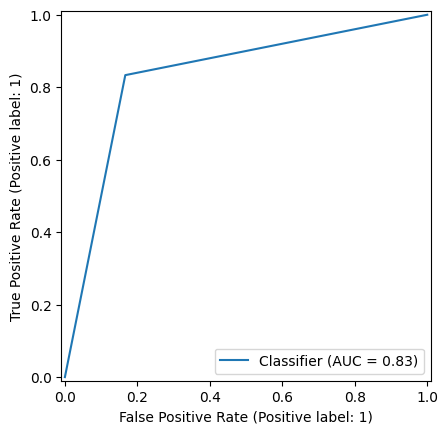

In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier()

test_model(xgb)
#  Same as GradientBoosting

RandomForestClassifier(max_features=10, n_estimators=200)

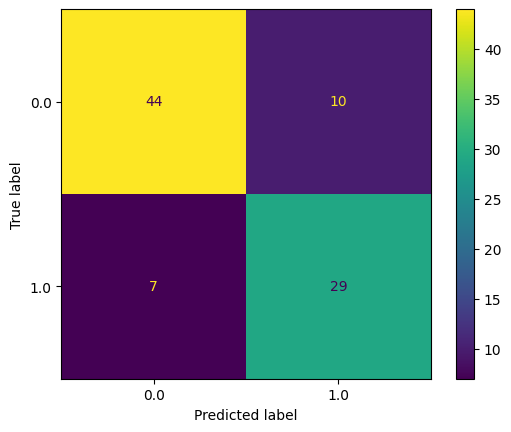

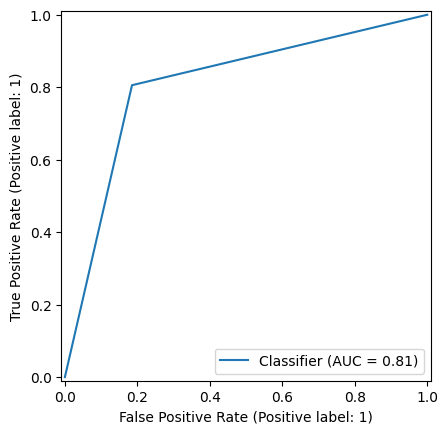

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=200, max_features=10)

test_model(rfc)
#  Pretty good, bud poorly scalable

1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 1 / 9 / 18 / 26 / 34 / 42 / 51 / 59 / 67 / 76 / 84 / 92 / 100 / 109 / 117 / 125 / 134 / 142 / 150 / 159 / 167 / 175 / 183 / 192 / 200 / 

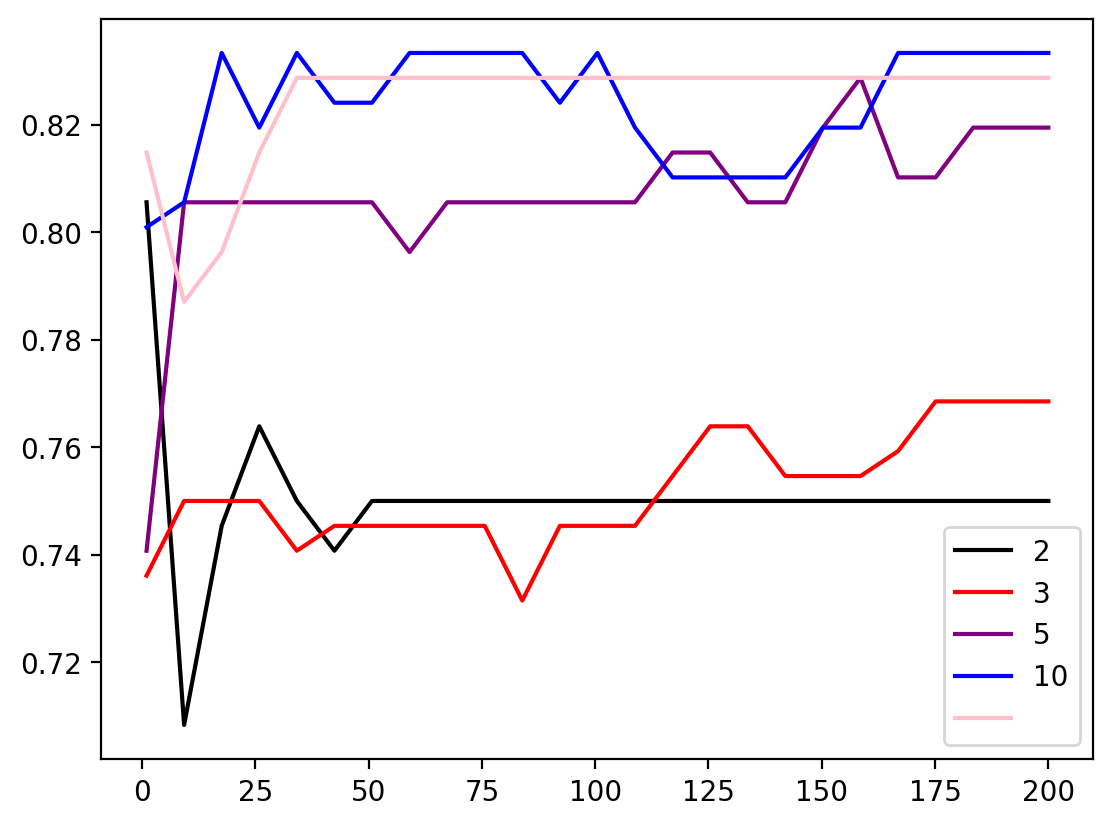

In [111]:
from sklearn.metrics import roc_auc_score

errors = []
range = np.linspace(1, 200, 25)
c = -1
colors = ['black', 'red', 'purple', 'blue', 'pink']
plt.figure(dpi=200)

for j in [2, 3, 5, 10, None]:
  errors = []
  c += 1
  for i in range:
    print(round(i), end=' / ')
    rfc = RandomForestClassifier(n_estimators=round(i), max_depth=j, random_state=42).fit(scaled_X_train, y_train)
    preds = rfc.predict(scaled_X_test)

    errors.append(roc_auc_score(y_test, preds))
  plt.plot(range, errors, color=colors[c])

plt.legend([2, 3, 5, 10, None])
plt.show()

Fitting 3 folds for each of 135 candidates, totalling 405 fits
{'criterion': 'entropy', 'max_features': 5, 'min_impurity_decrease': 0.01, 'min_weight_fraction_leaf': 0}


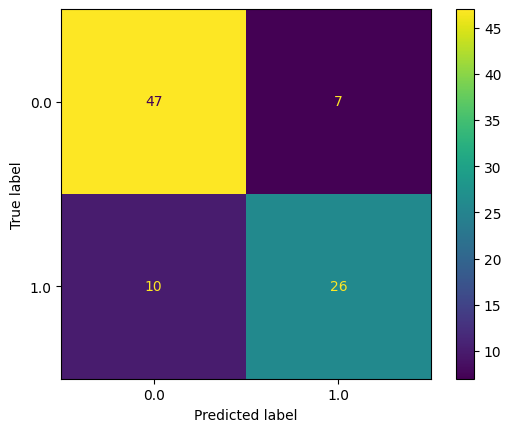

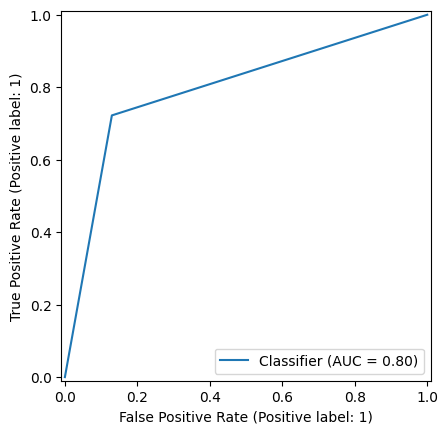

In [110]:
model = RandomForestClassifier(random_state=42, max_features=10, n_estimators=80)

param_grid = {'criterion' : ['gini', 'entropy', 'log_loss'],
              'max_features' : ['sqrt', 'log2', 1, 3, 5],
              'min_impurity_decrease' : [.01, .1, 0],
              'min_weight_fraction_leaf' : [.01, .1, 0]}

grid = test_grid(model, param_grid, cv=3, verbose=1)

In [112]:
grid.best_params_
#  After testing, varience was too high after overfitting the forest

{'criterion': 'entropy',
 'max_features': 5,
 'min_impurity_decrease': 0.01,
 'min_weight_fraction_leaf': 0}

KNeighborsClassifier()

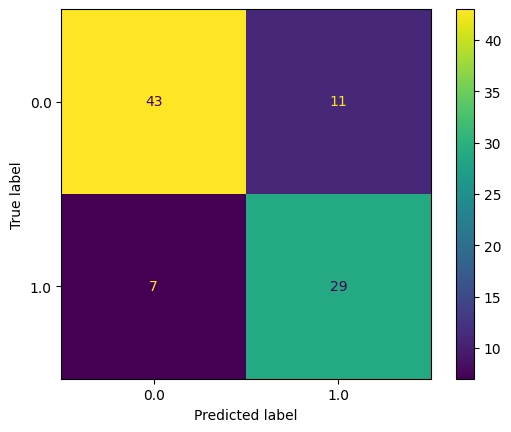

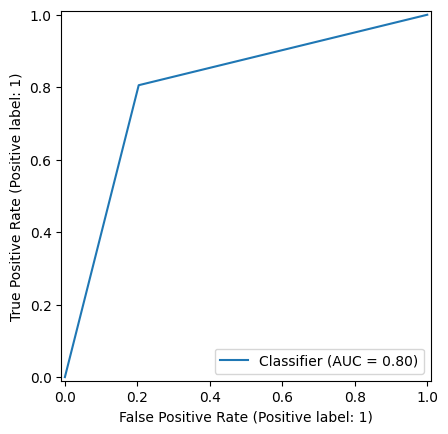

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

test_model(KNeighborsClassifier())
#  Bad

1 / 3 / 5 / 7 / 9 / 11 / 13 / 15 / 17 / 19 / 21 / 23 / 25 / 27 / 29 / 31 / 33 / 35 / 37 / 39 / 41 / 43 / 45 / 47 / 49 / 52 / 54 / 56 / 58 / 60 / 62 / 64 / 66 / 68 / 70 / 72 / 74 / 76 / 78 / 80 / 82 / 84 / 86 / 88 / 90 / 92 / 94 / 96 / 98 / 100 / 

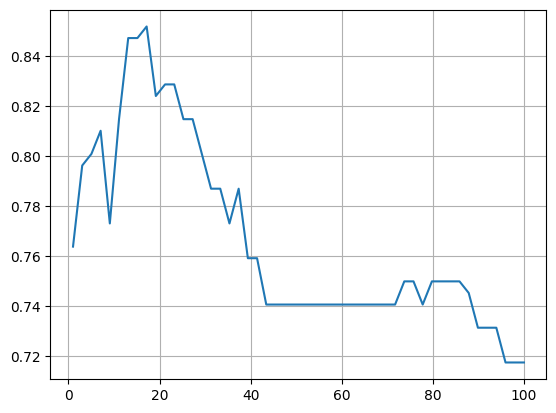

In [113]:
from sklearn.metrics import roc_auc_score

errors = []
range = np.linspace(1, 100, 50)

for i in range:
  print(round(i), end=' / ')
  knn = KNeighborsClassifier(round(i)).fit(scaled_X_train, y_train)
  preds = knn.predict(scaled_X_test)

  errors.append(roc_auc_score(y_test, preds))

plt.plot(range, errors)
plt.grid(True)
plt.show()
#  Value of 15-20 isn't too bad overall, but still lacking

LogisticRegression()

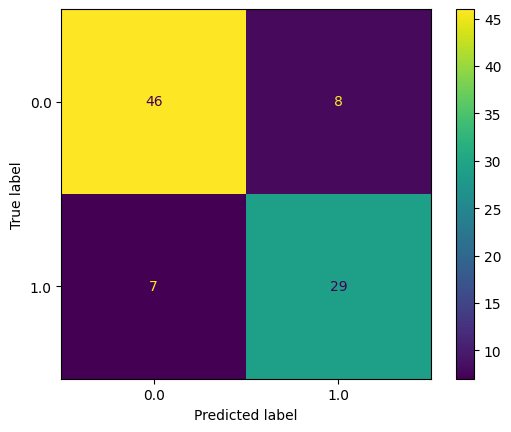

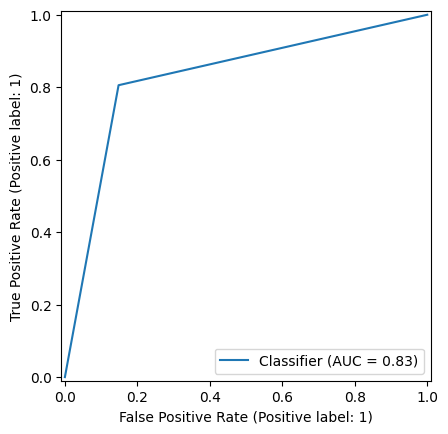

In [ ]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

test_model(lr)
#  Very good, bad with adaboosting though

VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3))),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow...
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('lr', LogisticRegression())],
                 voting='soft')

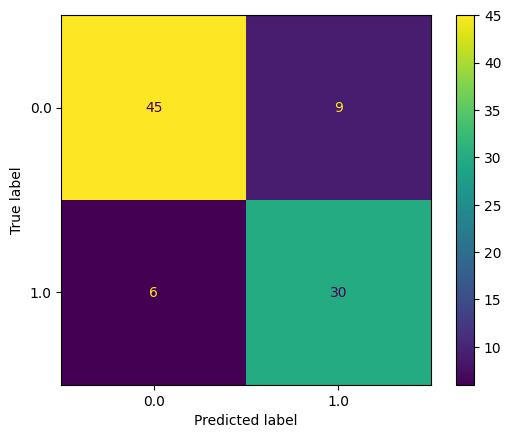

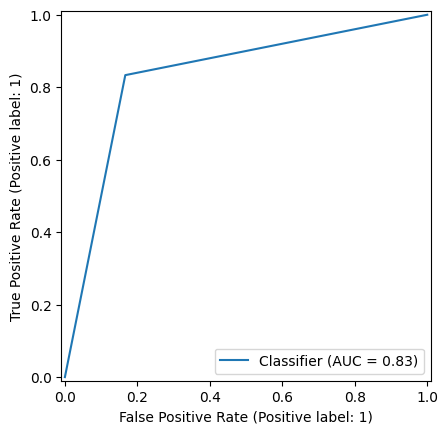

In [ ]:
from sklearn.ensemble import VotingClassifier

vc = VotingClassifier([('ada', ada), ('xgb', xgb), ('lr', lr)], voting='soft')

test_model(vc)
#  Unfortunately useless, could be an answer with some further testing

In [ ]:
best = ada.fit(scaled_X, y)
preds = best.predict(scaled_test)

sub = pd.DataFrame([np.array(test_dum.index), preds]).transpose()
sub = pd.DataFrame({ 'PassengerId': test_dum.index.astype(int), 'Survived': preds.astype(int) })
sub = sub.set_index('PassengerId')

sub.to_csv('titanic_sub.csv')